In [8]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [11]:
DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'left' 'right' 'up']


In [67]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Using 800 files for validation.

label names: ['down' 'left' 'right' 'up']


In [68]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [69]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [70]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [71]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [72]:
label_names[[0,1,2,3]]

array(['down', 'left', 'right', 'up'], dtype='<U5')

In [73]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [74]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)

    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [89]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec, shading='auto')

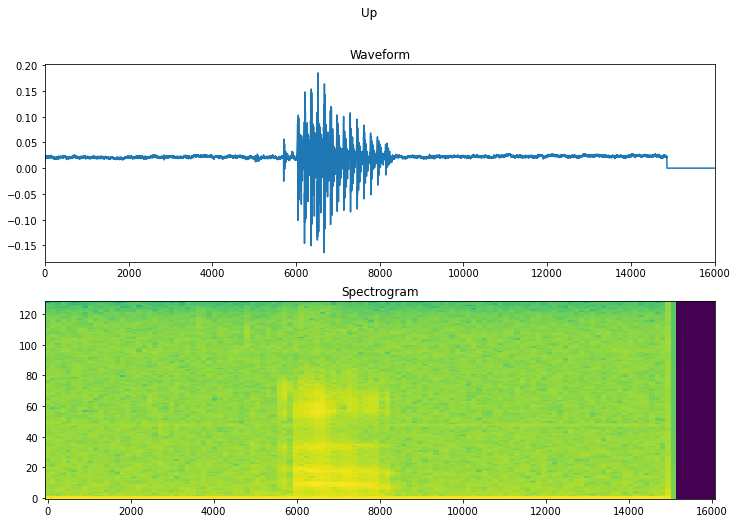

In [90]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [91]:
def make_spec_ds(ds):
    return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [92]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [93]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

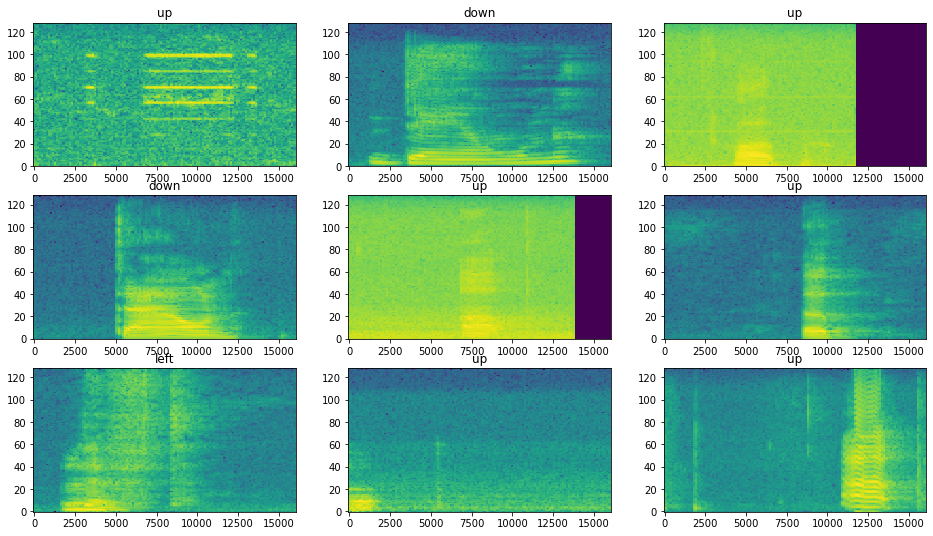

In [94]:
fig, axes = plt.subplots(3, 3, figsize=(16, 9))

for i in range(9):
    r = i // 3
    c = i % 3
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(commands[example_spect_labels[i].numpy()])

plt.show()

In [95]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [96]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin

In [97]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [46]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
50/50 [==============================] - 2s 31ms/step - loss: 0.1098 - accuracy: 0.9628 - val_loss: 0.1146 - val_accuracy: 0.9661
Epoch 2/10
50/50 [==============================] - 2s 32ms/step - loss: 0.0985 - accuracy: 0.9631 - val_loss: 0.1076 - val_accuracy: 0.9688
Epoch 3/10
50/50 [==============================] - 2s 34ms/step - loss: 0.0877 - accuracy: 0.9719 - val_loss: 0.1333 - val_accuracy: 0.9661
Epoch 4/10
50/50 [==============================] - 2s 41ms/step - loss: 0.1075 - accuracy: 0.9572 - val_loss: 0.1485 - val_accuracy: 0.9609
Epoch 4: early stopping


Text(0, 0.5, 'Accuracy [%]')

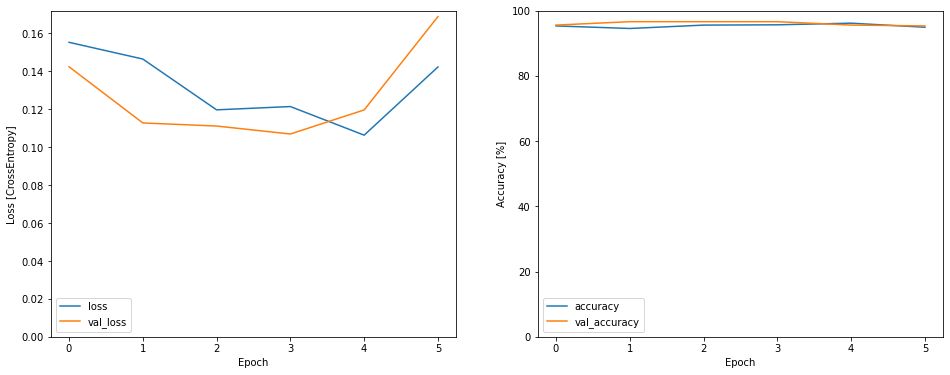

In [33]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [59]:
model.evaluate(test_spectrogram_ds, return_dict=True)

7/7 [==============================] - 0s 11ms/step - loss: 0.2930 - accuracy: 0.9303


{'loss': 0.2930147349834442, 'accuracy': 0.9302884340286255}

In [35]:
y_pred = model.predict(test_spectrogram_ds)

7/7 [==============================] - 0s 10ms/step


In [36]:
y_pred = tf.argmax(y_pred, axis=1)

In [37]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

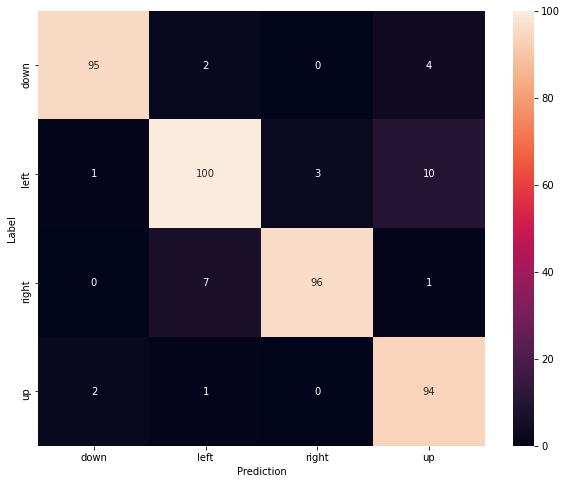

In [38]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [39]:
import sounddevice as sd
from scipy.io.wavfile import write
fs = 16000  # Sample rate
seconds = 1  # Duration of recording

In [106]:
print('start speaking')
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
sd.wait()  # Wait until recording is finished
write('output1.wav', fs, myrecording)  # Save as WAV file
print('stop speaking')

start speaking
stop speaking


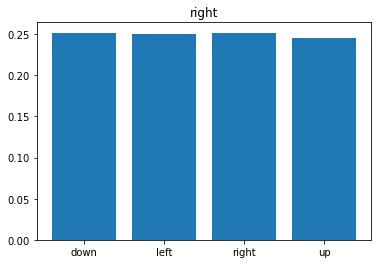

In [98]:
x = tf.squeeze(myrecording, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
predictions = tf.nn.softmax(prediction[0])
plt.bar(commands, predictions)
direction = commands[max(np.array(predictions))==np.array(predictions)]
plt.title(direction[0])
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [47]:
for i in range(10):
    print('start speaking')
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until recording is finished
    write('output1.wav', fs, myrecording)  # Save as WAV file
    print('stop speaking')
    x = tf.squeeze(myrecording, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]
    prediction = model(x)
    predictions = tf.nn.softmax(prediction[0])
    if max(np.array(predictions))<=.35:
        print('continue')
    else:
        direction = commands[max(np.array(predictions))==np.array(predictions)]
        print(direction[0], max(np.array(predictions)))

start speaking
stop speaking
left 0.2849192
start speaking
stop speaking
up 0.28432718
start speaking
stop speaking
left 0.29042837
start speaking
stop speaking
up 0.27398443
start speaking
stop speaking
left 0.29412156
start speaking
stop speaking
left 0.30824447
start speaking
stop speaking
up 0.2869317
start speaking
stop speaking
left 0.29669222
start speaking
stop speaking
left 0.3123515
start speaking
stop speaking
left 0.29349983


In [51]:
import pygame
import random

from pygame.locals import (
    RLEACCEL,
    K_UP,
    K_DOWN,
    K_LEFT,
    K_RIGHT,
    K_ESCAPE,
    K_SPACE,
    KEYDOWN,
    QUIT,
)

ppeg = 'rocket_.jpg'
epeg = 'asteroid.png'
count = lives = lc =  0
SCREEN_WIDTH = 1000
SCREEN_HEIGHT = 700

class Player(pygame.sprite.Sprite):
    def __init__(self):
        super(Player, self).__init__()
        self.surf = pygame.image.load(ppeg).convert()
        self.surf.set_colorkey((255, 255, 255), RLEACCEL)
        self.rect = self.surf.get_rect()
    def update(self, pressed_keys):
        if pressed_keys=='up':
            self.rect.move_ip(0, -90)
            move_up_sound.play()
        elif pressed_keys=='down':
            self.rect.move_ip(0, 90)
            move_up_sound.play()
        elif pressed_keys=='left':
            self.rect.move_ip(-90, 0)
            move_up_sound.play()
        elif pressed_keys=='right':
            self.rect.move_ip(90, 0)
            move_up_sound.play()
        
        if self.rect.left < 0:
            self.rect.left = 0
        elif self.rect.right > SCREEN_WIDTH:
            self.rect.right = SCREEN_WIDTH
        elif self.rect.top <= 0:
            self.rect.top = 0
        elif self.rect.bottom >= SCREEN_HEIGHT:
            self.rect.bottom = SCREEN_HEIGHT

class Enemy(pygame.sprite.Sprite):
    def __init__(self):
        super(Enemy, self).__init__()
        self.surf = pygame.image.load(epeg).convert()
        self.surf.set_colorkey((255, 255, 255), RLEACCEL)
        self.rect = self.surf.get_rect(
            center=(
                random.randint(SCREEN_WIDTH + 20, SCREEN_WIDTH + 100),
                random.randint(0, SCREEN_HEIGHT),
            )
        )
        self.speed = random.randint(50, 100)
    def update(self):
        self.rect.move_ip(-self.speed, 0)
        if self.rect.right < 0:
            self.kill()

In [54]:
pygame.mixer.init()
pause = False
running = True
collision_sound = pygame.mixer.Sound("explosion.mp3")
move_up_sound = pygame.mixer.Sound("move.wav")
go = pygame.mixer.Sound("game_over.wav")
pygame.init()
screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
exp = pygame.image.load('explosion03.png').convert()
ADDENEMY = pygame.USEREVENT + 2
pygame.time.set_timer(ADDENEMY, 750)
player = Player()
enemies = pygame.sprite.Group()
all_sprites = pygame.sprite.Group()
all_sprites.add(player)
clock = pygame.time.Clock()
while running:
    for event in pygame.event.get():
        if event.type == KEYDOWN:
            if event.key == K_ESCAPE:
                running = False
#             if event.key == K_SPACE:
#                 pause = not pause
        elif event.type == QUIT:
            running = False
        elif event.type == ADDENEMY:
            new_enemy = Enemy()
            enemies.add(new_enemy)
            all_sprites.add(new_enemy)
    myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=1)
    sd.wait()  # Wait until recording is finished
    write('output1.wav', fs, myrecording)  # Save as WAV file
    x = tf.squeeze(myrecording, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]
    prediction = model(x)
    predictions = tf.nn.softmax(prediction[0])
    if max(np.array(predictions))<=.35:
        pressed_keys = 'continue'
    else:
        direction = commands[max(np.array(predictions))==np.array(predictions)]
        pressed_keys = direction[0]
    player.update(pressed_keys)
    enemies.update()
    screen.fill((135, 206, 235))
    screen.blit(player.surf, player.rect)
    for entity in all_sprites:
        screen.blit(entity.surf, entity.rect)
    if pygame.sprite.spritecollideany(player, enemies):
        screen.blit(exp, player.rect)
        pygame.display.flip()
        collision_sound.play()
        pygame.time.wait(3500)
        go.play()
        pygame.time.wait(900)
        player.kill()
        running = False
    clock.tick(100)
    pygame.display.flip()
    count+=1
            
pygame.quit()
print('Score :', count, lives, lc)

Score : 54 0 0


In [58]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')